In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

import logging
from src.utils import setup_logging
setup_logging(console=True, file=True, debug=True, file_basename="k_sweep_BIG")
logger = logging.getLogger(__name__)

import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt

from src.plot import plot_predictive
from src.informed_np import InformedNeuralProcess
from tqdm import tqdm
# from src.loss import ELBOLoss
from src.loss import ELBOLoss
from src.train import train  

[INFO]: Logging setup completed at 09-08-2024-125957        (utils.py:62 [12:59:57])
/home/w/IML/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval(model, data, use_knowledge=True, num_context=None):
    model.training = False
    with torch.no_grad():
        test_loss = 0
        n_test_batches = 128
        test_batch_size = 96
        for _ in range(n_test_batches):
            batch = data.generate_batch(batch_size=test_batch_size,
                                    device=DEVICE,
                                    return_knowledge=use_knowledge,
                                    split='test',
                                    num_context=num_context)

            p_y_pred, q_z_context, q_z_target = model(batch.x_context,
                                                  batch.y_context,
                                                  batch.x_target,
                                                  batch.y_target,
                                                  batch.knowledge)
            test_loss_dict = loss_function(p_y_pred, q_z_context, None, batch.y_target)
            test_loss += test_loss_dict["loss"].item() / n_test_batches
        # val_losses.append(val_loss)
        
    model.training = True
    print(f"Test Loss: {test_loss}, use_knowledge={use_knowledge}, num_context={num_context}")
    return test_loss

def k_and_nok_eval(model, data):
    k_test_losses = []
    nok_test_losses = []

    for num_context in range(1, 11):
        k_test_losses.append(eval(model, data, use_knowledge=True, num_context=num_context))
        nok_test_losses.append(eval(model, data, use_knowledge=False, num_context=num_context))

    return k_test_losses, nok_test_losses




In [6]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f'Using DEVICE: {DEVICE}')



x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder

args = dict(
            x_dim=x_dim,
            y_dim=y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            determ_dim=determ_dim,
            knowledge_dim=128,
            mlps_activation=nn.GELU(),
            x_proj_dim=1,
            n_h_layers_x_proj=0,
            n_h_layers_decoder=4,
            n_h_layers_latent_xy_encoder=3,
            n_h_layers_film_latent_encoder=3,
            path='latent',
            train_num_z_samples=4,
            test_num_z_samples=32,
            use_bias=True,
            use_context_in_target=True, # TODO investigate
            use_latent_self_attn=True,
            # use_determ_self_attn=True,
            # use_determ_cross_attn=True,
            # use_knowledge=USE_KNOWLEDGE,
            # knowledge_dropout=0.3,
            roberta_return_cls=True,
            tune_llm_layer_norms=True,
            freeze_llm=True,
            knowledge_projection_n_h_layers=0,
            knowledge_aggregation_method='FiLM+MLP',
            device='cuda',
            beta=1.0
        )
assert "use_knowledge" not in args


data_path = '../data/data_with_desc.csv'
data_df = pd.read_csv(data_path, header=None)


AVG_LOSS_PRINT_INTERVAL = 250
PLOT_SAMPLE_INTERVAL = 1000
MAX_ITERS = 10000

LEARNING_RATE = 1e-3
loss_function = ELBOLoss(beta=1, reduction='mean')
random_states = [85, 98, 87]

MAX_NUM_CONTEXT = 10



[INFO]: Using DEVICE: cuda:0        (2228291297.py:2 [13:03:00])


[INFO]: USE_KNOWLEDGE: False        (4055599156.py:3 [18:49:21])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:49:22])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:49:22])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [18:49:22])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [18:49:23])


iter 1: Val. Loss (NLL): 28969.228775024414


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter1.pt'        (train.py:129 [18:49:29])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-85_iter250.pt        (train.py:134 [18:49:29])


iter 250: Val. Loss (NLL): 968.0972871780396


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter250.pt'        (train.py:129 [18:49:34])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-85_iter500.pt        (train.py:134 [18:49:34])


iter 500: Val. Loss (NLL): 646.2111339569092


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter500.pt'        (train.py:129 [18:49:40])
[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/np-kdropsweep-rs-85_iter750.pt        (train.py:134 [18:49:40])


iter 750: Val. Loss (NLL): 629.3298308849335
iter 1000: Val. Loss (NLL): 699.6114690303802
iter 1250: Val. Loss (NLL): 692.8386590480804


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter750.pt'        (train.py:129 [18:49:56])
[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/np-kdropsweep-rs-85_iter1500.pt        (train.py:134 [18:49:56])


iter 1500: Val. Loss (NLL): 628.8479392528534


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter1500.pt'        (train.py:129 [18:50:02])
[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/np-kdropsweep-rs-85_iter1750.pt        (train.py:134 [18:50:02])


iter 1750: Val. Loss (NLL): 616.3929204940796
iter 2000: Val. Loss (NLL): 672.6857483386993


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter1750.pt'        (train.py:129 [18:50:13])
[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/np-kdropsweep-rs-85_iter2250.pt        (train.py:134 [18:50:13])


iter 2250: Val. Loss (NLL): 589.4025626182556


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter2250.pt'        (train.py:129 [18:50:18])
[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/np-kdropsweep-rs-85_iter2500.pt        (train.py:134 [18:50:18])


iter 2500: Val. Loss (NLL): 584.6883726119995


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-85_iter2500.pt'        (train.py:129 [18:50:24])
[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/np-kdropsweep-rs-85_iter2750.pt        (train.py:134 [18:50:24])


iter 2750: Val. Loss (NLL): 579.3064754009247
iter 3000: Val. Loss (NLL): 581.8033258914948
iter 3250: Val. Loss (NLL): 583.9852061271667
iter 3500: Val. Loss (NLL): 586.5678007602692
iter 3750: Val. Loss (NLL): 596.9749784469604
iter 4000: Val. Loss (NLL): 590.2237818241119
iter 4250: Val. Loss (NLL): 768.0699255466461
iter 4500: Val. Loss (NLL): 639.0331978797913
iter 4750: Val. Loss (NLL): 727.2978830337524
iter 5000: Val. Loss (NLL): 876.2186222076416


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [18:51:18])


iter 5250: Val. Loss (NLL): 856.4041180610657


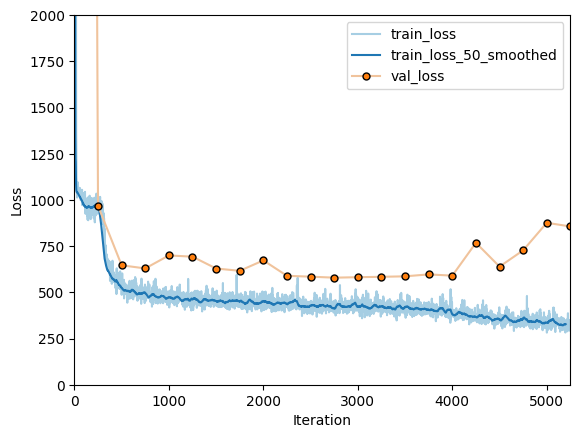

Test Loss: 1006.5791883468628, use_knowledge=True, num_context=1
Test Loss: 1012.0907711982727, use_knowledge=False, num_context=1
Test Loss: 728.449006319046, use_knowledge=True, num_context=2
Test Loss: 761.5460214614868, use_knowledge=False, num_context=2
Test Loss: 628.6000521183014, use_knowledge=True, num_context=3
Test Loss: 645.144374370575, use_knowledge=False, num_context=3
Test Loss: 603.2209765911102, use_knowledge=True, num_context=4
Test Loss: 602.1953821182251, use_knowledge=False, num_context=4
Test Loss: 552.5739986896515, use_knowledge=True, num_context=5
Test Loss: 556.8957753181458, use_knowledge=False, num_context=5
Test Loss: 540.7045822143555, use_knowledge=True, num_context=6
Test Loss: 516.0806894302368, use_knowledge=False, num_context=6
Test Loss: 504.8012180328369, use_knowledge=True, num_context=7
Test Loss: 522.406435251236, use_knowledge=False, num_context=7
Test Loss: 511.2703878879547, use_knowledge=True, num_context=8
Test Loss: 497.6449246406555, use_

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:51:49])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:51:49])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [18:51:49])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [18:51:51])


iter 1: Val. Loss (NLL): 30170.923629760742


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter1.pt'        (train.py:129 [18:51:56])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-98_iter250.pt        (train.py:134 [18:51:56])


iter 250: Val. Loss (NLL): 975.2767009735107


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter250.pt'        (train.py:129 [18:52:02])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-98_iter500.pt        (train.py:134 [18:52:02])


iter 500: Val. Loss (NLL): 741.3750095367432


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter500.pt'        (train.py:129 [18:52:07])
[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/np-kdropsweep-rs-98_iter750.pt        (train.py:134 [18:52:07])


iter 750: Val. Loss (NLL): 733.5922365188599
iter 1000: Val. Loss (NLL): 737.9018919467926


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter750.pt'        (train.py:129 [18:52:18])
[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/np-kdropsweep-rs-98_iter1250.pt        (train.py:134 [18:52:18])


iter 1250: Val. Loss (NLL): 696.6216633319855
iter 1500: Val. Loss (NLL): 732.1405000686646
iter 1750: Val. Loss (NLL): 748.0168046951294
iter 2000: Val. Loss (NLL): 763.0986139774323
iter 2250: Val. Loss (NLL): 713.3795614242554


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-98_iter1250.pt'        (train.py:129 [18:52:46])
[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/np-kdropsweep-rs-98_iter2500.pt        (train.py:134 [18:52:46])


iter 2500: Val. Loss (NLL): 649.8346524238586
iter 2750: Val. Loss (NLL): 694.5643577575684
iter 3000: Val. Loss (NLL): 766.376537322998
iter 3250: Val. Loss (NLL): 826.2008385658264
iter 3500: Val. Loss (NLL): 816.441243648529
iter 3750: Val. Loss (NLL): 798.708384513855
iter 4000: Val. Loss (NLL): 758.3381495475769
iter 4250: Val. Loss (NLL): 767.6525256633759
iter 4500: Val. Loss (NLL): 762.1277067661285
iter 4750: Val. Loss (NLL): 957.1742031574249


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [18:53:39])


iter 5000: Val. Loss (NLL): 796.3923959732056


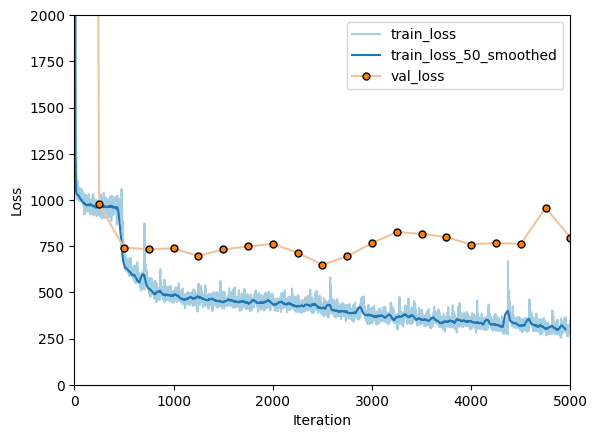

Test Loss: 1058.1254019737244, use_knowledge=True, num_context=1
Test Loss: 1065.7832293510437, use_knowledge=False, num_context=1
Test Loss: 756.7950346469879, use_knowledge=True, num_context=2
Test Loss: 730.5250885486603, use_knowledge=False, num_context=2
Test Loss: 597.451810836792, use_knowledge=True, num_context=3
Test Loss: 579.7816488742828, use_knowledge=False, num_context=3
Test Loss: 542.9775724411011, use_knowledge=True, num_context=4
Test Loss: 539.7402439117432, use_knowledge=False, num_context=4
Test Loss: 508.3082685470581, use_knowledge=True, num_context=5
Test Loss: 522.9060094356537, use_knowledge=False, num_context=5
Test Loss: 488.77636337280273, use_knowledge=True, num_context=6
Test Loss: 491.55005717277527, use_knowledge=False, num_context=6
Test Loss: 481.4914150238037, use_knowledge=True, num_context=7
Test Loss: 471.43521451950073, use_knowledge=False, num_context=7
Test Loss: 473.89375615119934, use_knowledge=True, num_context=8
Test Loss: 460.2603394985199

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:54:10])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [18:54:10])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [18:54:10])
[INFO]: Saving new best val loss model at iter 1        (train.py:122 [18:54:12])


iter 1: Val. Loss (NLL): 25907.59422302246


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter1.pt'        (train.py:129 [18:54:17])
[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/np-kdropsweep-rs-87_iter250.pt        (train.py:134 [18:54:17])


iter 250: Val. Loss (NLL): 948.5368084907532


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter250.pt'        (train.py:129 [18:54:22])
[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/np-kdropsweep-rs-87_iter500.pt        (train.py:134 [18:54:22])


iter 500: Val. Loss (NLL): 605.0614242553711
iter 750: Val. Loss (NLL): 622.4333591461182
iter 1000: Val. Loss (NLL): 642.8373236656189
iter 1250: Val. Loss (NLL): 624.720538854599
iter 1500: Val. Loss (NLL): 675.9983887672424
iter 1750: Val. Loss (NLL): 700.535236120224
iter 2000: Val. Loss (NLL): 657.4794399738312
iter 2250: Val. Loss (NLL): 651.5154201984406


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter500.pt'        (train.py:129 [18:55:07])
[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/np-kdropsweep-rs-87_iter2500.pt        (train.py:134 [18:55:07])


iter 2500: Val. Loss (NLL): 602.0592858791351
iter 2750: Val. Loss (NLL): 700.8338353633881
iter 3000: Val. Loss (NLL): 612.6509699821472


[INFO]: Removing model at path '../exp/sweep/np-kdropsweep-rs-87_iter2500.pt'        (train.py:129 [18:55:23])
[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/np-kdropsweep-rs-87_iter3250.pt        (train.py:134 [18:55:23])


iter 3250: Val. Loss (NLL): 593.7520513534546
iter 3500: Val. Loss (NLL): 603.6270821094513
iter 3750: Val. Loss (NLL): 726.6893162727356
iter 4000: Val. Loss (NLL): 764.5245776176453
iter 4250: Val. Loss (NLL): 777.5373511314392
iter 4500: Val. Loss (NLL): 863.7256760597229
iter 4750: Val. Loss (NLL): 909.2448041439056
iter 5000: Val. Loss (NLL): 804.9406661987305
iter 5250: Val. Loss (NLL): 760.5495722293854
iter 5500: Val. Loss (NLL): 876.6945333480835


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [18:56:18])


iter 5750: Val. Loss (NLL): 917.614232301712


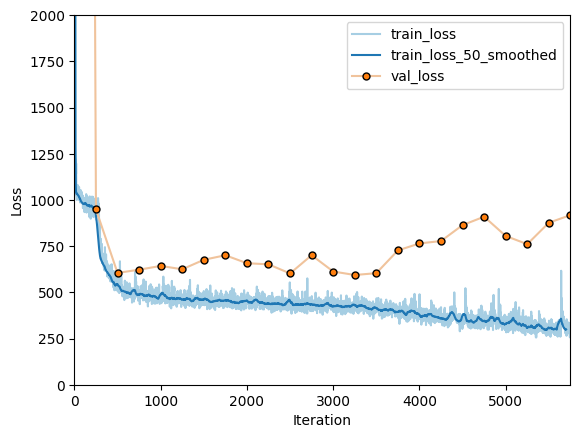

Test Loss: 976.1034531593323, use_knowledge=True, num_context=1
Test Loss: 969.0267391204834, use_knowledge=False, num_context=1
Test Loss: 719.7435884475708, use_knowledge=True, num_context=2
Test Loss: 748.5932722091675, use_knowledge=False, num_context=2
Test Loss: 624.9567701816559, use_knowledge=True, num_context=3
Test Loss: 629.2334270477295, use_knowledge=False, num_context=3
Test Loss: 552.1492011547089, use_knowledge=True, num_context=4
Test Loss: 596.8730976581573, use_knowledge=False, num_context=4
Test Loss: 564.057942867279, use_knowledge=True, num_context=5
Test Loss: 561.9019575119019, use_knowledge=False, num_context=5
Test Loss: 518.6934099197388, use_knowledge=True, num_context=6
Test Loss: 532.7137696743011, use_knowledge=False, num_context=6
Test Loss: 528.8669412136078, use_knowledge=True, num_context=7
Test Loss: 520.9828181266785, use_knowledge=False, num_context=7
Test Loss: 504.13225960731506, use_knowledge=True, num_context=8
Test Loss: 506.0716118812561, use

In [15]:
#### NP ####
USE_KNOWLEDGE = False
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

np_k_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
np_nok_test_losses = np.zeros((len(random_states), MAX_NUM_CONTEXT))
for idx, random_state in enumerate(random_states):
    data = TempData(data=data_df , max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)

    np_model = InformedNeuralProcess(
        **args,
        use_knowledge=USE_KNOWLEDGE
    ).to(DEVICE)
    np_optimiser = torch.optim.Adam(np_model.parameters(), lr=LEARNING_RATE)
    
    np_model, best_np_model_path, optimiser, train_losses, val_losses = train(model=np_model,
                                                       data=data,
                                                       loss_function=loss_function,
                                                       optimiser=np_optimiser,
                                                       device=DEVICE,
                                                       use_knowledge=USE_KNOWLEDGE,
                                                       max_iters=MAX_ITERS,
                                                       avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                       plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                       model_save_name=f"sweep/np-kdropsweep-rs-{random_state}",
                                                                               verbose=False)
    np_model.load_state_dict(torch.load(best_np_model_path))
    k_test_losses, nok_test_losses = k_and_nok_eval(np_model, data)
    np_k_test_losses[idx] = k_test_losses
    np_nok_test_losses[idx] = nok_test_losses

print()
print(np_k_test_losses.mean(axis=0), np_k_test_losses.std(axis=0))
print(np_nok_test_losses.mean(axis=0), np_nok_test_losses.std(axis=0))





In [16]:
np.save("np_k_test_losses1.npy", np_k_test_losses) 
np.save("np_nok_test_losses1.npy", np_nok_test_losses) 

[INFO]: USE_KNOWLEDGE: True        (1201216243.py:3 [13:41:39])
[INFO]: Knowledge Dropout 0.2        (1201216243.py:9 [13:41:39])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [13:41:39])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [13:41:39])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [13:41:39])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [13:41:39])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [13:41:40])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [13:41:40])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able

iter 1: Val. Loss (NLL): 25337.39273071289


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [13:42:14])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1.pt'        (train.py:129 [13:42:49])


iter 250: Val. Loss (NLL): 973.1203455924988


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter250.pt        (train.py:134 [13:42:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter250.pt'        (train.py:129 [13:43:27])


iter 500: Val. Loss (NLL): 640.7295598983765


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter500.pt        (train.py:134 [13:43:28])


iter 750: Val. Loss (NLL): 870.7768259048462
iter 1000: Val. Loss (NLL): 641.4878873825073


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter500.pt'        (train.py:129 [13:45:16])


iter 1250: Val. Loss (NLL): 618.6207408905029


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1250.pt        (train.py:134 [13:45:17])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1250.pt'        (train.py:129 [13:45:54])


iter 1500: Val. Loss (NLL): 609.989019870758


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1500.pt        (train.py:134 [13:45:55])


iter 1750: Val. Loss (NLL): 712.3190655708313


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter1500.pt'        (train.py:129 [13:47:05])


iter 2000: Val. Loss (NLL): 596.0069077014923


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2000.pt        (train.py:134 [13:47:06])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2000.pt'        (train.py:129 [13:47:43])


iter 2250: Val. Loss (NLL): 573.405975818634


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2250.pt        (train.py:134 [13:47:44])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2250.pt'        (train.py:129 [13:48:21])


iter 2500: Val. Loss (NLL): 558.5099582672119


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2500.pt        (train.py:134 [13:48:23])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2500.pt'        (train.py:129 [13:48:58])


iter 2750: Val. Loss (NLL): 498.39862084388733


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2750.pt        (train.py:134 [13:48:59])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter2750.pt'        (train.py:129 [13:49:35])


iter 3000: Val. Loss (NLL): 492.45401334762573


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter3000.pt        (train.py:134 [13:49:37])


iter 3250: Val. Loss (NLL): 504.067911863327


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-85_iter3000.pt'        (train.py:129 [13:50:49])


iter 3500: Val. Loss (NLL): 470.343266248703


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-85_iter3500.pt        (train.py:134 [13:50:50])


iter 3750: Val. Loss (NLL): 476.1815104484558
iter 4000: Val. Loss (NLL): 486.2178077697754
iter 4250: Val. Loss (NLL): 481.31263732910156
iter 4500: Val. Loss (NLL): 537.1697916984558
iter 4750: Val. Loss (NLL): 512.0100195407867
iter 5000: Val. Loss (NLL): 545.8161029815674
iter 5250: Val. Loss (NLL): 499.12145042419434
iter 5500: Val. Loss (NLL): 504.98310685157776
iter 5750: Val. Loss (NLL): 551.680999994278


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [13:56:53])


iter 6000: Val. Loss (NLL): 509.7631907463074


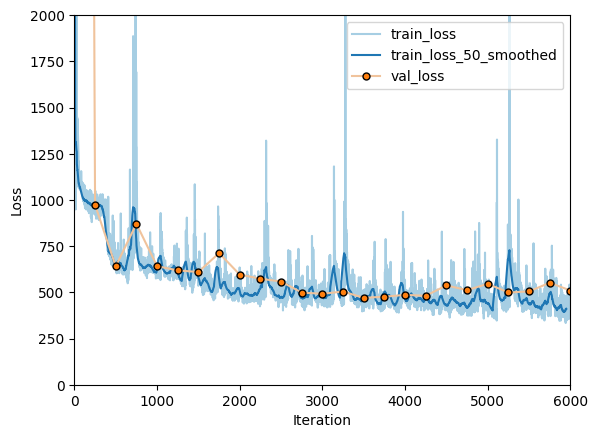

Test Loss: 604.4515435695648, use_knowledge=True, num_context=1
Test Loss: 1061.3393998146057, use_knowledge=False, num_context=1
Test Loss: 530.6115987300873, use_knowledge=True, num_context=2
Test Loss: 779.5370199680328, use_knowledge=False, num_context=2
Test Loss: 509.8955388069153, use_knowledge=True, num_context=3
Test Loss: 651.6241869926453, use_knowledge=False, num_context=3
Test Loss: 504.3521800041199, use_knowledge=True, num_context=4
Test Loss: 652.809488773346, use_knowledge=False, num_context=4
Test Loss: 493.40192699432373, use_knowledge=True, num_context=5
Test Loss: 585.7990691661835, use_knowledge=False, num_context=5
Test Loss: 491.41886949539185, use_knowledge=True, num_context=6
Test Loss: 558.9096217155457, use_knowledge=False, num_context=6
Test Loss: 481.9796853065491, use_knowledge=True, num_context=7
Test Loss: 564.1518650054932, use_knowledge=False, num_context=7
Test Loss: 484.99420642852783, use_knowledge=True, num_context=8
Test Loss: 545.0487072467804, 

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [13:59:26])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [13:59:26])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [13:59:26])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [13:59:26])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [13:59:27])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [13:59:27])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [13:59:49])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 25308.378952026367


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [14:00:06])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1.pt'        (train.py:129 [14:00:44])


iter 250: Val. Loss (NLL): 976.2759413719177


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter250.pt        (train.py:134 [14:00:45])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter250.pt'        (train.py:129 [14:01:23])


iter 500: Val. Loss (NLL): 952.5700602531433


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter500.pt        (train.py:134 [14:01:24])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter500.pt'        (train.py:129 [14:02:01])


iter 750: Val. Loss (NLL): 688.0149884223938


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter750.pt        (train.py:134 [14:02:02])


iter 1000: Val. Loss (NLL): 702.1083750724792


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter750.pt'        (train.py:129 [14:03:17])


iter 1250: Val. Loss (NLL): 674.504332780838


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1250.pt        (train.py:134 [14:03:18])


iter 1500: Val. Loss (NLL): 743.8861031532288


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1250.pt'        (train.py:129 [14:04:32])


iter 1750: Val. Loss (NLL): 583.2031862735748


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1750.pt        (train.py:134 [14:04:32])


iter 2000: Val. Loss (NLL): 627.1531076431274


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter1750.pt'        (train.py:129 [14:05:47])


iter 2250: Val. Loss (NLL): 574.4414854049683


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2250.pt        (train.py:134 [14:05:48])


iter 2500: Val. Loss (NLL): 606.8957946300507


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2250.pt'        (train.py:129 [14:07:02])


iter 2750: Val. Loss (NLL): 511.3317382335663


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2750.pt        (train.py:134 [14:07:03])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter2750.pt'        (train.py:129 [14:07:39])


iter 3000: Val. Loss (NLL): 506.20796608924866


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3000.pt        (train.py:134 [14:07:40])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3000.pt'        (train.py:129 [14:08:18])


iter 3250: Val. Loss (NLL): 501.27812671661377


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-98_iter3250.pt        (train.py:134 [14:08:19])


iter 3500: Val. Loss (NLL): 502.61684942245483
iter 3750: Val. Loss (NLL): 521.1550002098083
iter 4000: Val. Loss (NLL): 509.4056730270386
iter 4250: Val. Loss (NLL): 510.8840446472168
iter 4500: Val. Loss (NLL): 543.613436460495
iter 4750: Val. Loss (NLL): 553.0775218009949
iter 5000: Val. Loss (NLL): 592.7720484733582
iter 5250: Val. Loss (NLL): 566.1391110420227
iter 5500: Val. Loss (NLL): 695.6464762687683


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [14:14:25])


iter 5750: Val. Loss (NLL): 576.0099506378174


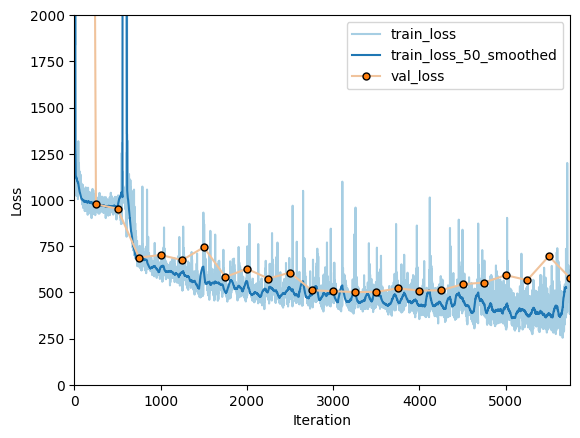

Test Loss: 556.4869060516357, use_knowledge=True, num_context=1
Test Loss: 929.028265953064, use_knowledge=False, num_context=1
Test Loss: 501.5837023258209, use_knowledge=True, num_context=2
Test Loss: 728.605447769165, use_knowledge=False, num_context=2
Test Loss: 485.0787432193756, use_knowledge=True, num_context=3
Test Loss: 680.2904763221741, use_knowledge=False, num_context=3
Test Loss: 476.2121801376343, use_knowledge=True, num_context=4
Test Loss: 609.825469493866, use_knowledge=False, num_context=4
Test Loss: 471.4630649089813, use_knowledge=True, num_context=5
Test Loss: 588.066153049469, use_knowledge=False, num_context=5
Test Loss: 469.27492594718933, use_knowledge=True, num_context=6
Test Loss: 573.6388320922852, use_knowledge=False, num_context=6
Test Loss: 466.9330184459686, use_knowledge=True, num_context=7
Test Loss: 567.3336520195007, use_knowledge=False, num_context=7
Test Loss: 466.6816020011902, use_knowledge=True, num_context=8
Test Loss: 564.7577776908875, use_kn

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:16:58])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:16:58])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [14:16:58])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [14:16:58])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:16:58])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:16:59])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [14:17:17])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 27176.32777404785


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [14:17:32])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1.pt'        (train.py:129 [14:18:06])


iter 250: Val. Loss (NLL): 946.6875329017639


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter250.pt        (train.py:134 [14:18:08])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter250.pt'        (train.py:129 [14:18:44])


iter 500: Val. Loss (NLL): 853.0744080543518


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter500.pt        (train.py:134 [14:18:45])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter500.pt'        (train.py:129 [14:19:21])


iter 750: Val. Loss (NLL): 633.1567420959473


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter750.pt        (train.py:134 [14:19:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter750.pt'        (train.py:129 [14:19:57])


iter 1000: Val. Loss (NLL): 604.4409065246582


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1000.pt        (train.py:134 [14:19:58])


iter 1250: Val. Loss (NLL): 616.3451571464539


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1000.pt'        (train.py:129 [14:21:09])


iter 1500: Val. Loss (NLL): 560.7852718830109


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1500.pt        (train.py:134 [14:21:10])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1500.pt'        (train.py:129 [14:21:45])


iter 1750: Val. Loss (NLL): 539.7994766235352


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1750.pt        (train.py:134 [14:21:46])


iter 2000: Val. Loss (NLL): 543.2272982597351


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter1750.pt'        (train.py:129 [14:22:56])


iter 2250: Val. Loss (NLL): 495.98724341392517


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2250.pt        (train.py:134 [14:22:58])


iter 2500: Val. Loss (NLL): 495.9874315261841
iter 2750: Val. Loss (NLL): 506.2965807914734
iter 3000: Val. Loss (NLL): 574.6345133781433


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.2-rs-87_iter2250.pt'        (train.py:129 [14:25:21])


iter 3250: Val. Loss (NLL): 492.32088708877563


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.2-rs-87_iter3250.pt        (train.py:134 [14:25:22])


iter 3500: Val. Loss (NLL): 539.2007462978363
iter 3750: Val. Loss (NLL): 543.8220000267029
iter 4000: Val. Loss (NLL): 525.2452352046967
iter 4250: Val. Loss (NLL): 558.366925239563
iter 4500: Val. Loss (NLL): 560.5567965507507
iter 4750: Val. Loss (NLL): 524.4319095611572
iter 5000: Val. Loss (NLL): 542.891832113266
iter 5250: Val. Loss (NLL): 599.9538354873657
iter 5500: Val. Loss (NLL): 638.6264615058899


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [14:31:17])


iter 5750: Val. Loss (NLL): 703.1542339324951


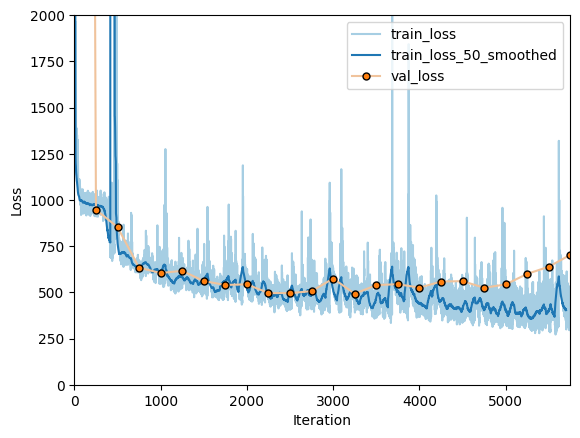

Test Loss: 545.1094121932983, use_knowledge=True, num_context=1
Test Loss: 843.2029910087585, use_knowledge=False, num_context=1
Test Loss: 528.4534120559692, use_knowledge=True, num_context=2
Test Loss: 677.131947517395, use_knowledge=False, num_context=2
Test Loss: 523.4852423667908, use_knowledge=True, num_context=3
Test Loss: 628.3076667785645, use_knowledge=False, num_context=3
Test Loss: 521.9188928604126, use_knowledge=True, num_context=4
Test Loss: 584.8915030956268, use_knowledge=False, num_context=4
Test Loss: 518.7884964942932, use_knowledge=True, num_context=5
Test Loss: 560.8093862533569, use_knowledge=False, num_context=5
Test Loss: 517.6850264072418, use_knowledge=True, num_context=6
Test Loss: 549.7876422405243, use_knowledge=False, num_context=6
Test Loss: 519.9451868534088, use_knowledge=True, num_context=7
Test Loss: 545.4614810943604, use_knowledge=False, num_context=7
Test Loss: 515.9991390705109, use_knowledge=True, num_context=8
Test Loss: 536.9329104423523, use_

[INFO]: Knowledge Dropout 0.4        (1201216243.py:9 [14:33:54])


Test Loss: 534.4029159545898, use_knowledge=False, num_context=10

[568.6826206  520.2162377  506.1531748  500.827751   494.5511628
 492.79294062 489.61929687 489.2249825  488.57843248 487.06297565] [25.7154134  13.20461973 15.90112701 18.82537466 19.33760888 19.78720985
 22.30613142 20.35484324 22.73174396 22.08079332]
[944.52355226 728.42480508 653.40744336 615.84215379 578.22486949
 560.77869868 558.98233271 548.91313179 548.81769578 539.32794229] [89.7253258  41.8068909  21.25932148 28.05189907 12.34933762  9.82649143
  9.64852367 11.68349668  8.69763368  7.69583617]


[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:33:54])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:33:54])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [14:33:54])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [14:33:54])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:33:54])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:33:54])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [14:34:16])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 24906.583740234375


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [14:34:32])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1.pt'        (train.py:129 [14:35:08])


iter 250: Val. Loss (NLL): 963.337429523468


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter250.pt        (train.py:134 [14:35:10])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter250.pt'        (train.py:129 [14:35:44])


iter 500: Val. Loss (NLL): 647.1877775192261


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter500.pt        (train.py:134 [14:35:45])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter500.pt'        (train.py:129 [14:36:21])


iter 750: Val. Loss (NLL): 623.0658593177795


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter750.pt        (train.py:134 [14:36:23])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter750.pt'        (train.py:129 [14:36:58])


iter 1000: Val. Loss (NLL): 601.338408946991


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1000.pt        (train.py:134 [14:36:59])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1000.pt'        (train.py:129 [14:37:35])


iter 1250: Val. Loss (NLL): 566.6538197994232


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1250.pt        (train.py:134 [14:37:36])


iter 1500: Val. Loss (NLL): 624.310690164566


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1250.pt'        (train.py:129 [14:38:46])


iter 1750: Val. Loss (NLL): 549.0419330596924


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1750.pt        (train.py:134 [14:38:48])


iter 2000: Val. Loss (NLL): 549.2024307250977


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter1750.pt'        (train.py:129 [14:39:57])


iter 2250: Val. Loss (NLL): 487.27329087257385


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2250.pt        (train.py:134 [14:39:58])


iter 2500: Val. Loss (NLL): 514.6799652576447
iter 2750: Val. Loss (NLL): 505.9631497859955
iter 3000: Val. Loss (NLL): 493.89436173439026


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-85_iter2250.pt'        (train.py:129 [14:42:21])


iter 3250: Val. Loss (NLL): 473.2466678619385


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-85_iter3250.pt        (train.py:134 [14:42:22])


iter 3500: Val. Loss (NLL): 520.0681881904602
iter 3750: Val. Loss (NLL): 485.9487376213074
iter 4000: Val. Loss (NLL): 494.3730640411377
iter 4250: Val. Loss (NLL): 561.4974522590637
iter 4500: Val. Loss (NLL): 510.78041768074036
iter 4750: Val. Loss (NLL): 501.04338669776917
iter 5000: Val. Loss (NLL): 524.0887565612793
iter 5250: Val. Loss (NLL): 511.1197588443756
iter 5500: Val. Loss (NLL): 538.8706696033478


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [14:48:24])


iter 5750: Val. Loss (NLL): 606.8792834281921


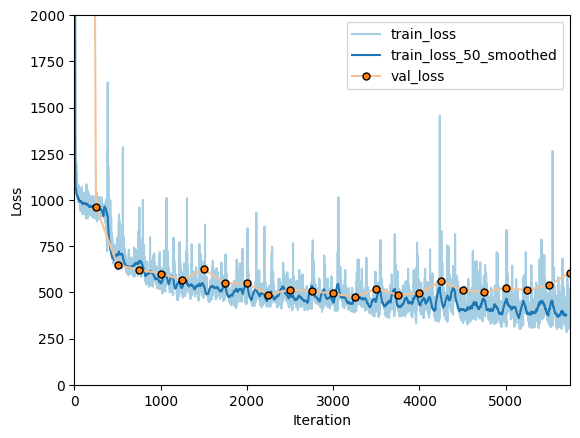

Test Loss: 623.9356637001038, use_knowledge=True, num_context=1
Test Loss: 1047.9126896858215, use_knowledge=False, num_context=1
Test Loss: 533.665853023529, use_knowledge=True, num_context=2
Test Loss: 786.5469846725464, use_knowledge=False, num_context=2
Test Loss: 509.6349079608917, use_knowledge=True, num_context=3
Test Loss: 688.2059519290924, use_knowledge=False, num_context=3
Test Loss: 492.36959767341614, use_knowledge=True, num_context=4
Test Loss: 608.8511464595795, use_knowledge=False, num_context=4
Test Loss: 483.86130928993225, use_knowledge=True, num_context=5
Test Loss: 587.0995285511017, use_knowledge=False, num_context=5
Test Loss: 479.30403447151184, use_knowledge=True, num_context=6
Test Loss: 547.777040719986, use_knowledge=False, num_context=6
Test Loss: 475.5887575149536, use_knowledge=True, num_context=7
Test Loss: 543.6172914505005, use_knowledge=False, num_context=7
Test Loss: 470.1531102657318, use_knowledge=True, num_context=8
Test Loss: 515.690122127533, us

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:50:55])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [14:50:56])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [14:50:56])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [14:50:56])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:50:56])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [14:50:56])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [14:51:17])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 27043.659561157227


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [14:51:34])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1.pt'        (train.py:129 [14:52:10])


iter 250: Val. Loss (NLL): 980.5801963806152


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter250.pt        (train.py:134 [14:52:11])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter250.pt'        (train.py:129 [14:52:49])


iter 500: Val. Loss (NLL): 930.3495154380798


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter500.pt        (train.py:134 [14:52:50])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter500.pt'        (train.py:129 [14:53:26])


iter 750: Val. Loss (NLL): 684.7929158210754


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter750.pt        (train.py:134 [14:53:27])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter750.pt'        (train.py:129 [14:54:03])


iter 1000: Val. Loss (NLL): 671.7193274497986


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1000.pt        (train.py:134 [14:54:05])


iter 1250: Val. Loss (NLL): 712.6206865310669


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1000.pt'        (train.py:129 [14:55:18])


iter 1500: Val. Loss (NLL): 656.1013870239258


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1500.pt        (train.py:134 [14:55:20])


iter 1750: Val. Loss (NLL): 679.4948706626892
iter 2000: Val. Loss (NLL): 691.2341737747192
iter 2250: Val. Loss (NLL): 703.2088418006897


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter1500.pt'        (train.py:129 [14:57:46])


iter 2500: Val. Loss (NLL): 653.1594657897949


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2500.pt        (train.py:134 [14:57:47])


iter 2750: Val. Loss (NLL): 744.8264532089233
iter 3000: Val. Loss (NLL): 699.7787485122681
iter 3250: Val. Loss (NLL): 678.0438582897186
iter 3500: Val. Loss (NLL): 751.1565790176392
iter 3750: Val. Loss (NLL): 718.9266977310181


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter2500.pt'        (train.py:129 [15:01:25])


iter 4000: Val. Loss (NLL): 651.0941591262817


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter4000.pt        (train.py:134 [15:01:26])


iter 4250: Val. Loss (NLL): 695.631117105484
iter 4500: Val. Loss (NLL): 703.0809450149536
iter 4750: Val. Loss (NLL): 690.6655097007751


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter4000.pt'        (train.py:129 [15:03:54])


iter 5000: Val. Loss (NLL): 616.4827680587769


[INFO]: Saving new best val loss model at iter 5000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter5000.pt        (train.py:134 [15:03:55])


iter 5250: Val. Loss (NLL): 712.8389105796814


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter5000.pt'        (train.py:129 [15:05:09])


iter 5500: Val. Loss (NLL): 601.3462173938751


[INFO]: Saving new best val loss model at iter 5500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter5500.pt        (train.py:134 [15:05:10])


iter 5750: Val. Loss (NLL): 630.572380065918
iter 6000: Val. Loss (NLL): 608.9364850521088
iter 6250: Val. Loss (NLL): 608.7599580287933
iter 6500: Val. Loss (NLL): 621.1266095638275
iter 6750: Val. Loss (NLL): 716.9816155433655


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter5500.pt'        (train.py:129 [15:08:53])


iter 7000: Val. Loss (NLL): 590.6662454605103


[INFO]: Saving new best val loss model at iter 7000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter7000.pt        (train.py:134 [15:08:54])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-98_iter7000.pt'        (train.py:129 [15:09:30])


iter 7250: Val. Loss (NLL): 573.7109997272491


[INFO]: Saving new best val loss model at iter 7250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-98_iter7250.pt        (train.py:134 [15:09:31])


iter 7500: Val. Loss (NLL): 631.6568241119385
iter 7750: Val. Loss (NLL): 691.7058072090149
iter 8000: Val. Loss (NLL): 702.0790023803711
iter 8250: Val. Loss (NLL): 628.3646459579468
iter 8500: Val. Loss (NLL): 643.2958381175995
iter 8750: Val. Loss (NLL): 668.3821816444397
iter 9000: Val. Loss (NLL): 731.5708513259888
iter 9250: Val. Loss (NLL): 729.4287738800049
iter 9500: Val. Loss (NLL): 695.9853739738464


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:15:38])


iter 9750: Val. Loss (NLL): 666.8660612106323


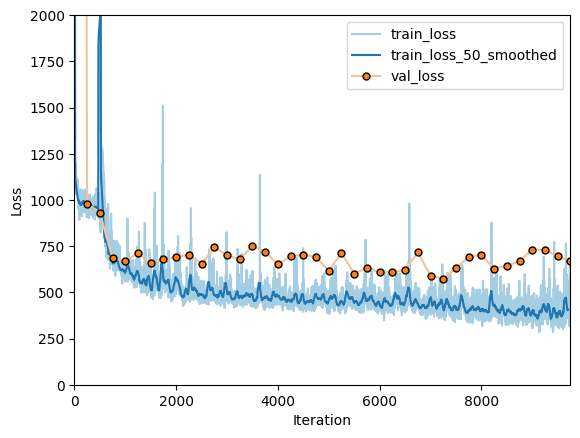

Test Loss: 745.9197430610657, use_knowledge=True, num_context=1
Test Loss: 874.4099631309509, use_knowledge=False, num_context=1
Test Loss: 614.8753063678741, use_knowledge=True, num_context=2
Test Loss: 655.37779545784, use_knowledge=False, num_context=2
Test Loss: 573.481057882309, use_knowledge=True, num_context=3
Test Loss: 579.3858337402344, use_knowledge=False, num_context=3
Test Loss: 558.7390553951263, use_knowledge=True, num_context=4
Test Loss: 543.6164474487305, use_knowledge=False, num_context=4
Test Loss: 545.8639481067657, use_knowledge=True, num_context=5
Test Loss: 516.3478267192841, use_knowledge=False, num_context=5
Test Loss: 535.1503024101257, use_knowledge=True, num_context=6
Test Loss: 493.6922302246094, use_knowledge=False, num_context=6
Test Loss: 524.8807907104492, use_knowledge=True, num_context=7
Test Loss: 491.14254117012024, use_knowledge=False, num_context=7
Test Loss: 526.5512118339539, use_knowledge=True, num_context=8
Test Loss: 488.95174646377563, use_

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:18:12])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:18:12])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:18:12])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [15:18:12])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:18:12])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:18:12])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [15:18:33])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 22889.406356811523


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:18:48])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1.pt'        (train.py:129 [15:19:24])


iter 250: Val. Loss (NLL): 949.6561455726624


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter250.pt        (train.py:134 [15:19:25])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter250.pt'        (train.py:129 [15:20:02])


iter 500: Val. Loss (NLL): 716.6559829711914


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter500.pt        (train.py:134 [15:20:03])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter500.pt'        (train.py:129 [15:20:39])


iter 750: Val. Loss (NLL): 642.5702652931213


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter750.pt        (train.py:134 [15:20:40])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter750.pt'        (train.py:129 [15:21:16])


iter 1000: Val. Loss (NLL): 608.9868159294128


[INFO]: Saving new best val loss model at iter 1000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1000.pt        (train.py:134 [15:21:17])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1000.pt'        (train.py:129 [15:21:54])


iter 1250: Val. Loss (NLL): 572.3302865028381


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1250.pt        (train.py:134 [15:21:55])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1250.pt'        (train.py:129 [15:22:30])


iter 1500: Val. Loss (NLL): 561.8109200000763


[INFO]: Saving new best val loss model at iter 1500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1500.pt        (train.py:134 [15:22:31])


iter 1750: Val. Loss (NLL): 644.4347515106201


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter1500.pt'        (train.py:129 [15:23:43])


iter 2000: Val. Loss (NLL): 510.87955594062805


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2000.pt        (train.py:134 [15:23:44])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2000.pt'        (train.py:129 [15:24:20])


iter 2250: Val. Loss (NLL): 495.46034836769104


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2250.pt        (train.py:134 [15:24:21])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2250.pt'        (train.py:129 [15:24:56])


iter 2500: Val. Loss (NLL): 494.4460783004761


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2500.pt        (train.py:134 [15:24:57])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2500.pt'        (train.py:129 [15:25:34])


iter 2750: Val. Loss (NLL): 481.3099982738495


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2750.pt        (train.py:134 [15:25:35])


iter 3000: Val. Loss (NLL): 493.3058936595917
iter 3250: Val. Loss (NLL): 516.6559586524963


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.4-rs-87_iter2750.pt'        (train.py:129 [15:27:23])


iter 3500: Val. Loss (NLL): 475.4470236301422


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.4-rs-87_iter3500.pt        (train.py:134 [15:27:25])


iter 3750: Val. Loss (NLL): 647.2737221717834
iter 4000: Val. Loss (NLL): 521.7092044353485
iter 4250: Val. Loss (NLL): 511.9887025356293
iter 4500: Val. Loss (NLL): 517.0238056182861
iter 4750: Val. Loss (NLL): 551.4813530445099
iter 5000: Val. Loss (NLL): 545.9471292495728
iter 5250: Val. Loss (NLL): 555.7067747116089
iter 5500: Val. Loss (NLL): 613.8094592094421
iter 5750: Val. Loss (NLL): 684.7372221946716


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:33:23])


iter 6000: Val. Loss (NLL): 694.7008666992188


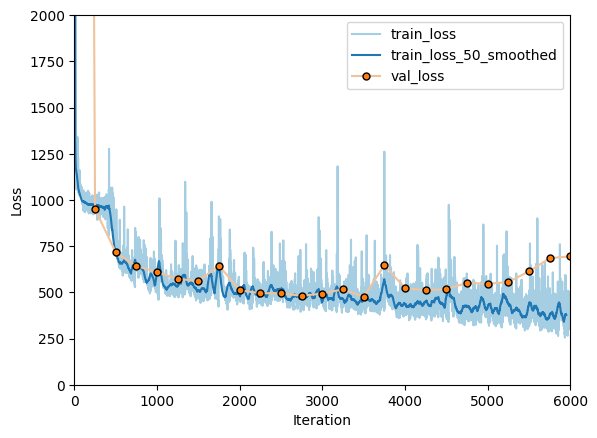

Test Loss: 535.2328879833221, use_knowledge=True, num_context=1
Test Loss: 1181.2868814468384, use_knowledge=False, num_context=1
Test Loss: 503.55996465682983, use_knowledge=True, num_context=2
Test Loss: 844.1319870948792, use_knowledge=False, num_context=2
Test Loss: 492.678640127182, use_knowledge=True, num_context=3
Test Loss: 679.1399285793304, use_knowledge=False, num_context=3
Test Loss: 491.20077204704285, use_knowledge=True, num_context=4
Test Loss: 658.5613076686859, use_knowledge=False, num_context=4
Test Loss: 488.66150188446045, use_knowledge=True, num_context=5
Test Loss: 605.292201757431, use_knowledge=False, num_context=5
Test Loss: 487.6316454410553, use_knowledge=True, num_context=6
Test Loss: 575.805014371872, use_knowledge=False, num_context=6
Test Loss: 486.5572929382324, use_knowledge=True, num_context=7
Test Loss: 580.2459542751312, use_knowledge=False, num_context=7
Test Loss: 486.87800431251526, use_knowledge=True, num_context=8
Test Loss: 569.9138934612274, u

[INFO]: Knowledge Dropout 0.6        (1201216243.py:9 [15:36:00])


Test Loss: 546.0123620033264, use_knowledge=False, num_context=10

[635.02943158 550.70037468 525.26486866 514.10314171 506.12891976
 500.69532744 495.67561372 494.52744214 491.53943165 489.25309968] [86.36952198 47.01352657 34.78964819 31.56596407 28.16516549 24.59940719
 21.13108239 23.65124224 21.42590744 19.83772599]
[1034.53651142  762.01892241  648.91057142  603.67630053  569.57985234
  539.09142844  538.3352623   524.85192068  522.59274594  516.33319012] [125.63850885  78.98630934  49.30054129  47.06849262  38.36647628
  34.08036801  36.56755785  33.68156     30.79960942  25.17985106]


[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:36:00])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:36:00])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:36:00])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [15:36:00])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:36:00])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:36:00])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [15:36:20])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 26906.25421142578


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:36:36])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1.pt'        (train.py:129 [15:37:11])


iter 250: Val. Loss (NLL): 968.4757814407349


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter250.pt        (train.py:134 [15:37:12])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter250.pt'        (train.py:129 [15:37:46])


iter 500: Val. Loss (NLL): 702.5030126571655


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter500.pt        (train.py:134 [15:37:48])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter500.pt'        (train.py:129 [15:38:24])


iter 750: Val. Loss (NLL): 615.0049571990967


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter750.pt        (train.py:134 [15:38:25])


iter 1000: Val. Loss (NLL): 634.6467161178589


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter750.pt'        (train.py:129 [15:39:36])


iter 1250: Val. Loss (NLL): 608.5255010128021


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1250.pt        (train.py:134 [15:39:37])


iter 1500: Val. Loss (NLL): 614.4695816040039


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1250.pt'        (train.py:129 [15:40:48])


iter 1750: Val. Loss (NLL): 598.1829378604889


[INFO]: Saving new best val loss model at iter 1750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1750.pt        (train.py:134 [15:40:50])


iter 2000: Val. Loss (NLL): 616.136479139328
iter 2250: Val. Loss (NLL): 634.4706935882568


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter1750.pt'        (train.py:129 [15:42:37])


iter 2500: Val. Loss (NLL): 564.0600554943085


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2500.pt        (train.py:134 [15:42:38])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2500.pt'        (train.py:129 [15:43:14])


iter 2750: Val. Loss (NLL): 551.3603053092957


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2750.pt        (train.py:134 [15:43:15])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter2750.pt'        (train.py:129 [15:43:52])


iter 3000: Val. Loss (NLL): 525.2672896385193


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3000.pt        (train.py:134 [15:43:53])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3000.pt'        (train.py:129 [15:44:29])


iter 3250: Val. Loss (NLL): 521.7331187725067


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3250.pt        (train.py:134 [15:44:30])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3250.pt'        (train.py:129 [15:45:05])


iter 3500: Val. Loss (NLL): 519.5785179138184


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3500.pt        (train.py:134 [15:45:06])


iter 3750: Val. Loss (NLL): 540.8416082859039


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter3500.pt'        (train.py:129 [15:46:17])


iter 4000: Val. Loss (NLL): 484.41832160949707


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4000.pt        (train.py:134 [15:46:18])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4000.pt'        (train.py:129 [15:46:52])


iter 4250: Val. Loss (NLL): 476.33190989494324


[INFO]: Saving new best val loss model at iter 4250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-85_iter4250.pt        (train.py:134 [15:46:53])


iter 4500: Val. Loss (NLL): 491.3213737010956
iter 4750: Val. Loss (NLL): 524.3243062496185
iter 5000: Val. Loss (NLL): 497.4552822113037
iter 5250: Val. Loss (NLL): 526.6632344722748
iter 5500: Val. Loss (NLL): 494.412602186203
iter 5750: Val. Loss (NLL): 566.8793635368347
iter 6000: Val. Loss (NLL): 542.633273601532
iter 6250: Val. Loss (NLL): 591.3940062522888
iter 6500: Val. Loss (NLL): 660.4991235733032


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [15:52:57])


iter 6750: Val. Loss (NLL): 686.3406462669373


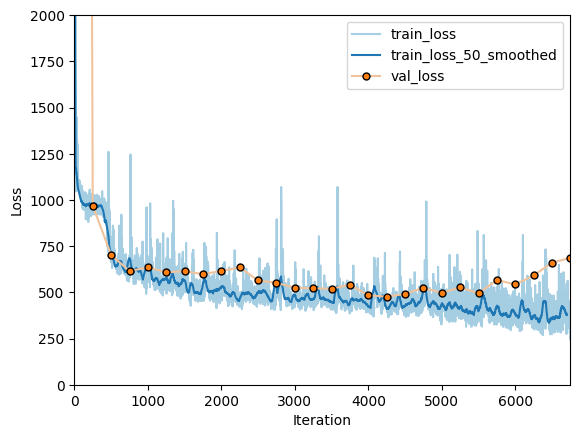

Test Loss: 587.2323818206787, use_knowledge=True, num_context=1
Test Loss: 919.832691192627, use_knowledge=False, num_context=1
Test Loss: 518.5659422874451, use_knowledge=True, num_context=2
Test Loss: 756.0526130199432, use_knowledge=False, num_context=2
Test Loss: 497.13761711120605, use_knowledge=True, num_context=3
Test Loss: 619.6183881759644, use_knowledge=False, num_context=3
Test Loss: 481.99553513526917, use_knowledge=True, num_context=4
Test Loss: 589.4935669898987, use_knowledge=False, num_context=4
Test Loss: 477.13460755348206, use_knowledge=True, num_context=5
Test Loss: 565.230936050415, use_knowledge=False, num_context=5
Test Loss: 470.3793342113495, use_knowledge=True, num_context=6
Test Loss: 547.1242439746857, use_knowledge=False, num_context=6
Test Loss: 467.0820164680481, use_knowledge=True, num_context=7
Test Loss: 529.2708439826965, use_knowledge=False, num_context=7
Test Loss: 468.1981678009033, use_knowledge=True, num_context=8
Test Loss: 516.8741810321808, us

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:55:31])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [15:55:31])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [15:55:31])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [15:55:31])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:55:31])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [15:55:31])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [15:55:52])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 28885.10319519043


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [15:56:09])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1.pt'        (train.py:129 [15:56:44])


iter 250: Val. Loss (NLL): 982.5420370101929


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter250.pt        (train.py:134 [15:56:45])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter250.pt'        (train.py:129 [15:57:21])


iter 500: Val. Loss (NLL): 914.5623888969421


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter500.pt        (train.py:134 [15:57:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter500.pt'        (train.py:129 [15:58:00])


iter 750: Val. Loss (NLL): 651.7707958221436


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter750.pt        (train.py:134 [15:58:01])


iter 1000: Val. Loss (NLL): 661.0146737098694


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter750.pt'        (train.py:129 [15:59:13])


iter 1250: Val. Loss (NLL): 635.3086438179016


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1250.pt        (train.py:134 [15:59:15])


iter 1500: Val. Loss (NLL): 652.5289092063904
iter 1750: Val. Loss (NLL): 690.0687003135681
iter 2000: Val. Loss (NLL): 668.0974810123444


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter1250.pt'        (train.py:129 [16:01:43])


iter 2250: Val. Loss (NLL): 607.0550215244293


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2250.pt        (train.py:134 [16:01:44])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2250.pt'        (train.py:129 [16:02:21])


iter 2500: Val. Loss (NLL): 586.1384236812592


[INFO]: Saving new best val loss model at iter 2500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2500.pt        (train.py:134 [16:02:22])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2500.pt'        (train.py:129 [16:02:58])


iter 2750: Val. Loss (NLL): 515.6489191055298


[INFO]: Saving new best val loss model at iter 2750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2750.pt        (train.py:134 [16:02:59])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter2750.pt'        (train.py:129 [16:03:36])


iter 3000: Val. Loss (NLL): 505.4649534225464


[INFO]: Saving new best val loss model at iter 3000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter3000.pt        (train.py:134 [16:03:37])


iter 3250: Val. Loss (NLL): 519.3187193870544


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter3000.pt'        (train.py:129 [16:04:51])


iter 3500: Val. Loss (NLL): 483.2401633262634


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter3500.pt        (train.py:134 [16:04:52])


iter 3750: Val. Loss (NLL): 525.9109313488007


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-98_iter3500.pt'        (train.py:129 [16:06:04])


iter 4000: Val. Loss (NLL): 478.83353543281555


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-98_iter4000.pt        (train.py:134 [16:06:06])


iter 4250: Val. Loss (NLL): 481.45065665245056
iter 4500: Val. Loss (NLL): 479.41439747810364
iter 4750: Val. Loss (NLL): 512.2640953063965
iter 5000: Val. Loss (NLL): 514.2388610839844
iter 5250: Val. Loss (NLL): 524.855414390564
iter 5500: Val. Loss (NLL): 597.1432781219482
iter 5750: Val. Loss (NLL): 584.1516671180725
iter 6000: Val. Loss (NLL): 586.5727143287659
iter 6250: Val. Loss (NLL): 665.5455861091614


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [16:12:17])


iter 6500: Val. Loss (NLL): 733.4104428291321


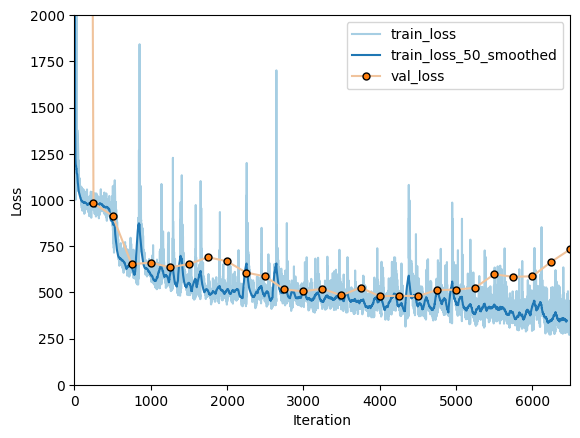

Test Loss: 524.0948441028595, use_knowledge=True, num_context=1
Test Loss: 1117.663372039795, use_knowledge=False, num_context=1
Test Loss: 479.03361916542053, use_knowledge=True, num_context=2
Test Loss: 767.0450789928436, use_knowledge=False, num_context=2
Test Loss: 469.3671290874481, use_knowledge=True, num_context=3
Test Loss: 664.5253469944, use_knowledge=False, num_context=3
Test Loss: 465.50685930252075, use_knowledge=True, num_context=4
Test Loss: 617.9007592201233, use_knowledge=False, num_context=4
Test Loss: 461.1037368774414, use_knowledge=True, num_context=5
Test Loss: 561.0448281764984, use_knowledge=False, num_context=5
Test Loss: 461.58742332458496, use_knowledge=True, num_context=6
Test Loss: 543.0598130226135, use_knowledge=False, num_context=6
Test Loss: 460.6459267139435, use_knowledge=True, num_context=7
Test Loss: 525.8570716381073, use_knowledge=False, num_context=7
Test Loss: 458.9728841781616, use_knowledge=True, num_context=8
Test Loss: 524.2492783069611, use

[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:14:51])
[WARNING]: Hidden activation set but no hidden layers        (mlp.py:22 [16:14:51])
[DEBUG]: XYEncoder has x_dim=1 and y_dim=1        (xy_encoders.py:57 [16:14:51])
[DEBUG]: Resetting dropped connection: huggingface.co        (connectionpool.py:291 [16:14:51])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [16:14:51])
[DEBUG]: https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/11" 200 0        (connectionpool.py:546 [16:14:52])
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[DEBUG]: Freezing LLM parameters        (knowledge_encoder.py:30 [16:15:13])
[DEBUG]: Al

iter 1: Val. Loss (NLL): 26299.12159729004


[INFO]: Saving new best val loss model at iter 1        (train.py:122 [16:15:28])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter1.pt'        (train.py:129 [16:16:04])


iter 250: Val. Loss (NLL): 946.3582391738892


[INFO]: Saving new best val loss model at iter 250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter250.pt        (train.py:134 [16:16:05])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter250.pt'        (train.py:129 [16:16:41])


iter 500: Val. Loss (NLL): 705.7885932922363


[INFO]: Saving new best val loss model at iter 500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter500.pt        (train.py:134 [16:16:42])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter500.pt'        (train.py:129 [16:17:17])


iter 750: Val. Loss (NLL): 632.8385286331177


[INFO]: Saving new best val loss model at iter 750 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter750.pt        (train.py:134 [16:17:18])


iter 1000: Val. Loss (NLL): 721.6899199485779


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter750.pt'        (train.py:129 [16:18:30])


iter 1250: Val. Loss (NLL): 613.2456176280975


[INFO]: Saving new best val loss model at iter 1250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter1250.pt        (train.py:134 [16:18:31])


iter 1500: Val. Loss (NLL): 613.8461804389954
iter 1750: Val. Loss (NLL): 626.6055293083191


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter1250.pt'        (train.py:129 [16:20:17])


iter 2000: Val. Loss (NLL): 596.3723888397217


[INFO]: Saving new best val loss model at iter 2000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter2000.pt        (train.py:134 [16:20:19])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter2000.pt'        (train.py:129 [16:20:56])


iter 2250: Val. Loss (NLL): 577.056254863739


[INFO]: Saving new best val loss model at iter 2250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter2250.pt        (train.py:134 [16:20:57])


iter 2500: Val. Loss (NLL): 599.7461395263672
iter 2750: Val. Loss (NLL): 595.504204750061
iter 3000: Val. Loss (NLL): 578.0164034366608


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter2250.pt'        (train.py:129 [16:23:20])


iter 3250: Val. Loss (NLL): 547.131224155426


[INFO]: Saving new best val loss model at iter 3250 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter3250.pt        (train.py:134 [16:23:21])
[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter3250.pt'        (train.py:129 [16:23:57])


iter 3500: Val. Loss (NLL): 528.2287890911102


[INFO]: Saving new best val loss model at iter 3500 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter3500.pt        (train.py:134 [16:23:58])


iter 3750: Val. Loss (NLL): 604.4427161216736


[INFO]: Removing model at path '../exp/sweep/inp-kdropsweep-0.6-rs-87_iter3500.pt'        (train.py:129 [16:25:09])


iter 4000: Val. Loss (NLL): 514.717248916626


[INFO]: Saving new best val loss model at iter 4000 to path ../exp/sweep/inp-kdropsweep-0.6-rs-87_iter4000.pt        (train.py:134 [16:25:10])


iter 4250: Val. Loss (NLL): 522.5165350437164
iter 4500: Val. Loss (NLL): 541.9469385147095
iter 4750: Val. Loss (NLL): 582.1372215747833
iter 5000: Val. Loss (NLL): 541.9287564754486
iter 5250: Val. Loss (NLL): 606.6389179229736
iter 5500: Val. Loss (NLL): 624.7333383560181
iter 5750: Val. Loss (NLL): 555.4584083557129
iter 6000: Val. Loss (NLL): 686.4256300926208
iter 6250: Val. Loss (NLL): 655.6746764183044


[INFO]: time_since_prev_best_val >=5. EXITING TRAINING        (train.py:148 [16:31:11])


iter 6500: Val. Loss (NLL): 662.5387043952942


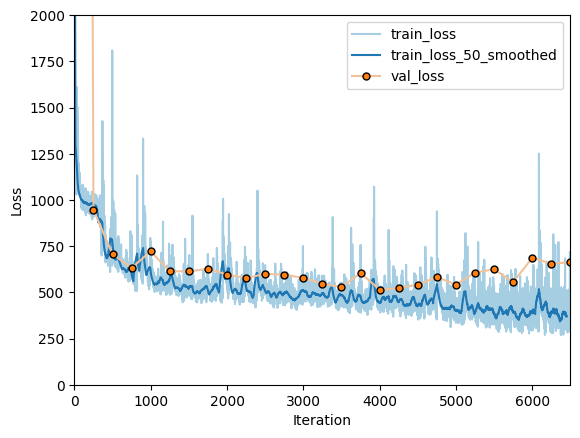

Test Loss: 599.5023760795593, use_knowledge=True, num_context=1
Test Loss: 1200.4113874435425, use_knowledge=False, num_context=1
Test Loss: 551.8902604579926, use_knowledge=True, num_context=2
Test Loss: 838.219916343689, use_knowledge=False, num_context=2
Test Loss: 527.3848350048065, use_knowledge=True, num_context=3
Test Loss: 723.89075756073, use_knowledge=False, num_context=3
Test Loss: 513.6219561100006, use_knowledge=True, num_context=4
Test Loss: 662.1572527885437, use_knowledge=False, num_context=4
Test Loss: 508.97445940971375, use_knowledge=True, num_context=5
Test Loss: 606.6550440788269, use_knowledge=False, num_context=5
Test Loss: 506.4657196998596, use_knowledge=True, num_context=6
Test Loss: 566.4570174217224, use_knowledge=False, num_context=6
Test Loss: 502.4405426979065, use_knowledge=True, num_context=7
Test Loss: 565.1963579654694, use_knowledge=False, num_context=7
Test Loss: 499.23228907585144, use_knowledge=True, num_context=8
Test Loss: 560.5515451431274, use

In [13]:
#### INP ####
USE_KNOWLEDGE = True
logging.info(f'USE_KNOWLEDGE: {USE_KNOWLEDGE}')

inp_k_test_losses = np.zeros((3, len(random_states), MAX_NUM_CONTEXT))
inp_nok_test_losses = np.zeros((3, len(random_states), MAX_NUM_CONTEXT))

for kidx, knowledge_dropout in enumerate([0.2, 0.4, 0.6]):
    logging.info(f"Knowledge Dropout {knowledge_dropout}")
    
    for ridx, random_state in enumerate(random_states):
        data = TempData(data=data_df, max_num_context=MAX_NUM_CONTEXT, device=DEVICE, random_state=random_state)
        
        inp_model = InformedNeuralProcess(
            **args,
            knowledge_dropout=knowledge_dropout,
            use_knowledge=USE_KNOWLEDGE
        ).to(DEVICE)
        inp_optimiser = torch.optim.Adam(inp_model.parameters(), lr=LEARNING_RATE)
        
        inp_model, best_inp_model_path, optimiser, train_losses, val_losses = train(model=inp_model,
                                                           data=data,
                                                           loss_function=loss_function,
                                                           optimiser=inp_optimiser,
                                                           device=DEVICE,
                                                           use_knowledge=USE_KNOWLEDGE,
                                                           max_iters=MAX_ITERS,
                                                           avg_loss_print_interval=AVG_LOSS_PRINT_INTERVAL,
                                                           plot_sample_interval=PLOT_SAMPLE_INTERVAL,
                                                           model_save_name=f"sweep/inp-kdropsweep-{knowledge_dropout}-rs-{random_state}",
                                                                                   verbose=False)
        inp_model.load_state_dict(torch.load(best_inp_model_path))
        k_test_losses, nok_test_losses = k_and_nok_eval(inp_model, data)
        inp_k_test_losses[kidx, ridx] = k_test_losses
        inp_nok_test_losses[kidx, ridx] = nok_test_losses
        
        print()
    print(inp_k_test_losses[kidx].mean(axis=0), inp_k_test_losses[kidx].std(axis=0))
    print(inp_nok_test_losses[kidx].mean(axis=0), inp_nok_test_losses[kidx].std(axis=0))

In [14]:
np.save("inp_k_test_losses.npy", inp_k_test_losses) 
np.save("inp_nok_test_losses.npy", inp_nok_test_losses) 

[WARNING]: 
Bad key /cycler('ls', ['-', '--', ' in file ../figures/mplstyles/thesis.mplstyle, line 8 ("/cycler('ls', ['-', '--', ':', '-.'])")
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution        (__init__.py:918 [19:06:06])


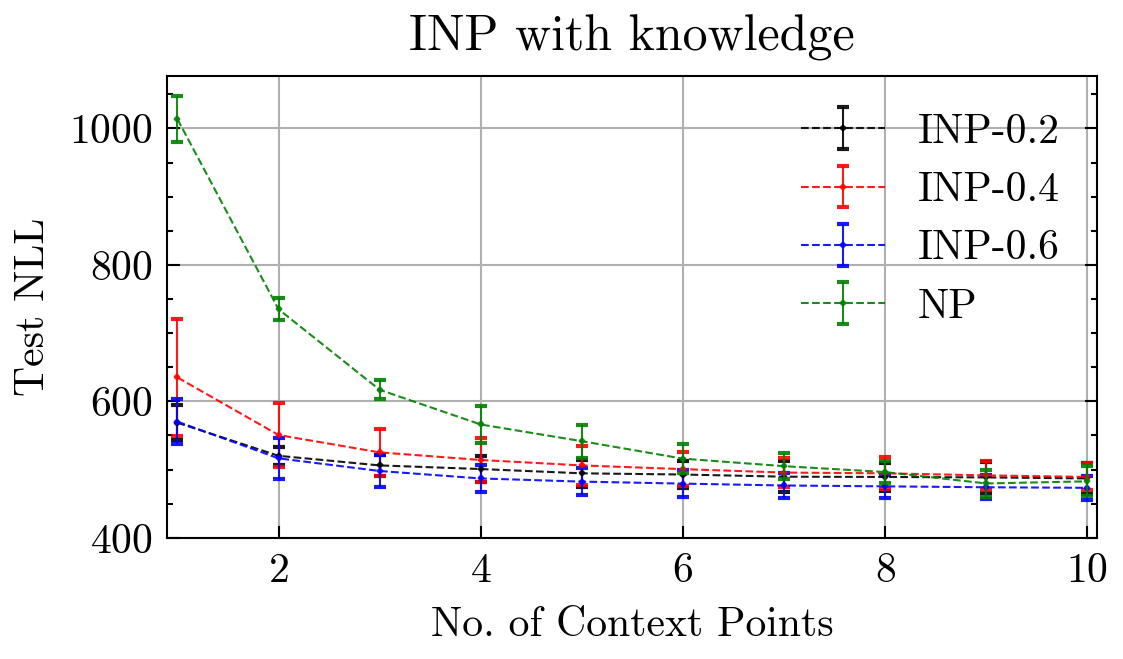

In [31]:
plt.style.use('../figures/mplstyles/thesis.mplstyle')

# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    plt.errorbar(num_context_points, 
                 inp_k_test_losses[i].mean(axis=0), 
                 yerr=inp_k_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='x', linestyle='--', markersize=1, linewidth=0.5,
                 alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")
plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='x', markersize=1,  linestyle='--', linewidth=0.5,
              alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP with knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
plt.grid()
# plt.savefig(f'../figures/nok-inp_vs_np_context_points.png', dpi=300)
plt.show()


In [ ]:
# Plot the data
# plt.figure(figsize=(10, 6))
num_context_points = range(1, 11)
# plt.plot(num_context_points, inp_test_losses_array.mean(axis=0), label='INP', marker='o', markersize=3)
# plt.plot(num_context_points, np_test_losses_array.mean(axis=0), label='NP', marker='x', markersize=3)
for i, k_dropout in enumerate([0.2, 0.4, 0.6]):
    plt.errorbar(num_context_points, 
                 inp_nok_test_losses[i].mean(axis=0), 
                 yerr=inp_nok_test_losses[i].std(axis=0), 
                 capsize=1.5,marker='o', markersize=2, alpha=0.9, mfc='white',zorder=11, label=f"INP-{k_dropout}")
plt.errorbar(num_context_points, 
             np_k_test_losses.mean(axis=0), 
             yerr=np_k_test_losses.std(axis=0), 
             capsize=1.5,  marker='o', markersize=2,  alpha=0.9, mfc='white',zorder=12, label="NP")

plt.xlabel('No. of Context Points')
plt.ylabel('Test NLL')
plt.title("INP without knowledge")
plt.legend()
plt.xlim(0.9, 10.1)
plt.ylim(400,)
# plt.savefig(f'../figures/nok-inp_vs_np_context_points.png', dpi=300)
plt.show()
